<a href="https://colab.research.google.com/github/musicjae/Reinforcement_Learning/blob/master/intro_RL/Atari_Breakdown_with_DQN_and_A3C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving 1.png to 1.png
User uploaded file "1.png" with length 92255 bytes


In [26]:
from IPython.display import Image

In [5]:
import matplotlib.pyplot as plt

# 1. Breakout Game with the CNN,DQN
  
아타리? 게임 회사. 2015년에 딥마인드에서 그 중 하나인 브레이크 아웃이란 벽돌 깨기 게임을 강화학습으로 훈련시켜 수행하는 것을 공개.  
  


## 1.1 수행  
  
- Agent 이동: 제자리, 왼쪽, 오른쪽  
- 보상:   
  - 벽돌 깸 --> +  
   > 뒤에 있는 벽돌일수록 높은 보상  
  - 아무것도 깨지 못하는 평소 상태 --> 0  
  - 공을 놓침 --> -1   

## 1.2 CNN  
  
- 게임 화면이 input인 경우 --> input vector 크기 증가 --> 영상인식 분야에서 널리 사용되는 CNN 사용 요구돼

### 1.2.1 Motivation of CNN  
  
###### 사람은 어떻게 시각 정보를 처리하는가?  
- 수용영역 Receptive Field  
- 추상화 Abstraction  
  > 수용영역을 가진 시신경은 전체 시각 input 중 **일부**에만 반응: 추상화  
- 시각 중추 Visual Cortex  
> 이것은 사람 시야의 전체를 쪼개서 여러 가지 조각으로 인식

###### CNN은 어떻게 이미지 정보를 처리하는가?  
- 컨볼루션 필터  
> 컨볼루션 필터는 알고리즘에서 시각 중추 같은 역할을 한다. 이것은 이미지의 Noise를 제거하거나 어떤 Features를 강조할 때 사용된다. // BOX 형태 필터가 popular

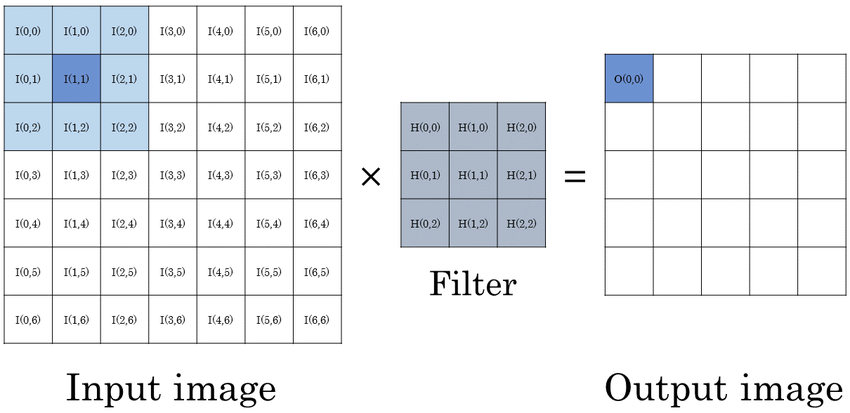

In [4]:
Image('11.png',width=800)

###### 필터는 어떻게 작동하는가? (주제 외)

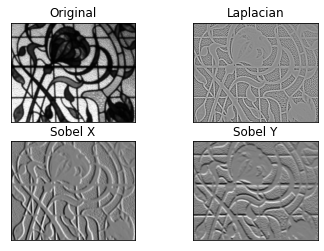

In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# loading image
#img0 = cv2.imread('SanFrancisco.jpg',)
img0 = cv2.imread('12.jpg',)

# converting to gray scale
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# remove noise
img = cv2.GaussianBlur(gray,(3,3),0)

# convolute with proper kernels
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

# https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php

위 사례에서 보듯이, 어떤 필터를 사용하는지에 따라 우리는 전혀 다른 정보를 얻을 수 있다. 따라서 실험자는 특정 목적에 맞게 필터를 사용하여 원하는 정보를 추출하는 것이 바람직하다.  
이 "Feature 추출"은 본래 유저가 수행했지만, CNN을 이용하면 사람이 직접하지 않아도 된다. 왜냐하면 CNN을 사용하면 <특징 추출 단계>를 거치지 않고 End-to-End로 학습하기 때문이다.

## 1.3 CNN in the Breakout

- {The number of filters, Size of filters, Stride, Activation} $\in$ Convolution Layer  
- 

In [ ]:
# example 

Conv = Conv2D(32, (8,8),strides=(4,4), activation='relu') # 필터 개수, 사이즈, 보폭stride, 활성화 함수

위 같은 컨볼루션 층을 3 개 쌓기

In [ ]:
Conv1 = Conv2D(32, (8,8),strides=(4,4), activation='relu')
Conv2 = Conv2D(32, (8,8),strides=(4,4), activation='relu')
Conv3 = Conv2D(32, (8,8),strides=(4,4), activation='relu')

위에서 쌓은 층들을 nodes를 일렬로 펼치기 위해 Flattening 하기

In [ ]:
flatten=Flatten()
fc = Dense(512,activation='relu')

이렇게 펼쳐진 nodes는 마지막에 action의 개수 만큼 Q함숫값을 출력한다.  
> 결국 이 과정은 CNN을 통해 Q함수를 근사하는 것이다.

# Applications

## 2.1 전처리  
  
전처리 --> 히스토리 만들기

In [ ]:
def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe

전처리를 하지 않으면 모델은 제대로 학습을 할 수 없다. 왜냐하면 모델은 전처리가 없이 입력된 이미지 하나만으로는 어떤 상황인지 인식하지 못하기 때문이다. 따라서 아래와 같이 "메인 루프" 안에서 하나의 이미지를 4 개로 복사하여 하나의 히스토리를 만들어준다. (지금 어떤 상황인지를 더 잘 인식하기 위해 이전 시점 상황과 나중 시점 상황을 살펴보기 위함)

In [ ]:
state = pre_processing(observe)
history = np.stack((state, state, state, state), axis=2) # state가 [84,84,1]의 형태를 갖으니, 그 1에 해당하는 축에 대해 axis를 쌓아줘야 해서, axis=2
history = np.reshape([history], (1, 84, 84, 4))

한 루프를 지날 때 마다, envs는 에이전트에게 새로운 observe를 제공해야 한다. 즉 오래된 state는 버리고 새로운 state를 제공한다.

In [ ]:
next_state = pre_processing(observe)
next_state = np.reshape([next_state], (1, 84, 84, 1))
next_history = np.append(next_state, history[:, :, :, :3], axis=3)

## 2.2 모델 만들기  
  
- 타깃 모델, 트레이닝 모델 만들기  
- optimizer

In [ ]:
# 모델과 타겟모델을 생성하고 타겟모델 초기화
self.model = self.build_model()
self.target_model = self.build_model()
self.update_target_model()
self.optimizer = self.optimizer()

## 2.3 행동 선택  
  
만들어진 이 모델은 행동을 선택할 수 있다. 이것은 model()을 이용해 출력한 **Q함수를_통해_선택**한다. 여기서 에이전트는 **$\epsilon$-탐욕정책을**통해 행동을 선택한다.

In [ ]:
# 입실론 탐욕 정책으로 행동 선택
    def get_action(self, history):
        history = np.float32(history / 255.0) # 픽셀 값을 0 - 255가 아닌 0 - 1 사이 값이 되도록 해준다.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(history)
            return np.argmax(q_value[0])

## 2.4 환경이 에이전트에게 정보 제공  


In [ ]:
# 선택한 행동으로 환경에서 한 타임스텝 진행
observe, reward, done, info = env.step(real_action)

## 2.5 정보를 리플레이에 저장  
  
한 스텝 진행 후, 환경에서 얻은 정보를 샘플로서 리플레이에 저장

In [ ]:
# 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
def append_sample(self, history, action, reward, next_history, dead):
    self.memory.append((history, action, reward, next_history, dead))

## 2.6 리플레이 메모리를 이용하여 학습 진행  
  
- 50000 스텝 이후부터 학습 (memory < 50000 $\to$ 학습 x)

In [ ]:
def train_model(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_step

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch = random.sample(self.memory, self.batch_size)

        history = np.array([sample[0][0] / 255. for sample in batch],
                           dtype=np.float32)
        actions = np.array([sample[1] for sample in batch])
        rewards = np.array([sample[2] for sample in batch])
        next_history = np.array([sample[3][0] / 255. for sample in batch],
                                dtype=np.float32)
        dones = np.array([sample[4] for sample in batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(history)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_history)

            # 벨만 최적 방정식을 구성하기 위한 타깃과 큐함수의 최대 값 계산
            max_q = np.amax(target_predicts, axis=1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q

## 2.7 전체 train.py

In [1]:
!pip install gym[atari] > /dev/null 2>&1

In [3]:
import os
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque

from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, Flatten


# 상태가 입력, 큐함수가 출력인 인공신경망 생성
class DQN(tf.keras.Model):
    def __init__(self, action_size, state_size):
        super(DQN, self).__init__()
        self.conv1 = Conv2D(32, (8, 8), strides=(4, 4), activation='relu',
                            input_shape=state_size)
        self.conv2 = Conv2D(64, (4, 4), strides=(2, 2), activation='relu')
        self.conv3 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')
        self.flatten = Flatten()
        self.fc = Dense(512, activation='relu')
        self.fc_out = Dense(action_size)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        q = self.fc_out(x)
        return q


# 브레이크아웃 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, action_size, state_size=(84, 84, 4)):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 1e-4
        self.epsilon = 1.
        self.epsilon_start, self.epsilon_end = 1.0, 0.02
        self.exploration_steps = 1000000.
        self.epsilon_decay_step = self.epsilon_start - self.epsilon_end
        self.epsilon_decay_step /= self.exploration_steps
        self.batch_size = 32
        self.train_start = 50000
        self.update_target_rate = 10000

        # 리플레이 메모리, 최대 크기 100,000
        self.memory = deque(maxlen=100000)
        # 게임 시작 후 랜덤하게 움직이지 않는 것에 대한 옵션
        self.no_op_steps = 30

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size, state_size)
        self.target_model = DQN(action_size, state_size)
        self.optimizer = Adam(self.learning_rate, clipnorm=10.)
        # 타깃 모델 초기화
        self.update_target_model()

        self.avg_q_max, self.avg_loss = 0, 0

        self.writer = tf.summary.create_file_writer('summary/breakout_dqn')
        self.model_path = os.path.join(os.getcwd(), 'save_model', 'model')

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, history):
        history = np.float32(history / 255.0)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(history)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, history, action, reward, next_history, dead):
        self.memory.append((history, action, reward, next_history, dead))

    # 텐서보드에 학습 정보를 기록
    def draw_tensorboard(self, score, step, episode):
        with self.writer.as_default():
            tf.summary.scalar('Total Reward/Episode', score, step=episode)
            tf.summary.scalar('Average Max Q/Episode',
                              self.avg_q_max / float(step), step=episode)
            tf.summary.scalar('Duration/Episode', step, step=episode)
            tf.summary.scalar('Average Loss/Episode',
                              self.avg_loss / float(step), step=episode)

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_step

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch = random.sample(self.memory, self.batch_size)

        history = np.array([sample[0][0] / 255. for sample in batch],
                           dtype=np.float32)
        actions = np.array([sample[1] for sample in batch])
        rewards = np.array([sample[2] for sample in batch])
        next_history = np.array([sample[3][0] / 255. for sample in batch],
                                dtype=np.float32)
        dones = np.array([sample[4] for sample in batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(history)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_history)

            # 벨만 최적 방정식을 구성하기 위한 타깃과 큐함수의 최대 값 계산
            max_q = np.amax(target_predicts, axis=1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q

            # 후버로스 계산
            error = tf.abs(targets - predicts)
            quadratic_part = tf.clip_by_value(error, 0.0, 1.0)
            linear_part = error - quadratic_part
            loss = tf.reduce_mean(0.5 * tf.square(quadratic_part) + linear_part)

            self.avg_loss += loss.numpy()

        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))


# 학습속도를 높이기 위해 흑백화면으로 전처리
def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe


if __name__ == "__main__":
    # 환경과 DQN 에이전트 생성
    env = gym.make('BreakoutDeterministic-v4')
    agent = DQNAgent(action_size=3)

    global_step = 0
    score_avg = 0
    score_max = 0

    # 불필요한 행동을 없애주기 위한 딕셔너리 선언
    action_dict = {0:1, 1:2, 2:3, 3:3}

    num_episode = 50000
    for e in range(num_episode):
        done = False
        dead = False

        step, score, start_life = 0, 0, 5
        # env 초기화
        observe = env.reset()

        # 랜덤으로 뽑힌 값 만큼의 프레임동안 움직이지 않음
        for _ in range(random.randint(1, agent.no_op_steps)):
            observe, _, _, _ = env.step(1)

        # 프레임을 전처리 한 후 4개의 상태를 쌓아서 입력값으로 사용.
        state = pre_processing(observe)
        history = np.stack((state, state, state, state), axis=2)
        history = np.reshape([history], (1, 84, 84, 4))

        while not done:
            if agent.render:
                env.render()
            global_step += 1
            step += 1

            # 바로 전 history를 입력으로 받아 행동을 선택
            action = agent.get_action(history)
            # 1: 정지, 2: 왼쪽, 3: 오른쪽
            real_action = action_dict[action]

            # 죽었을 때 시작하기 위해 발사 행동을 함
            if dead:
                action, real_action, dead = 0, 1, False

            # 선택한 행동으로 환경에서 한 타임스텝 진행
            observe, reward, done, info = env.step(real_action)
            # 각 타임스텝마다 상태 전처리
            next_state = pre_processing(observe)
            next_state = np.reshape([next_state], (1, 84, 84, 1))
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)

            agent.avg_q_max += np.amax(agent.model(np.float32(history / 255.))[0])

            if start_life > info['ale.lives']:
                dead = True
                start_life = info['ale.lives']

            score += reward
            reward = np.clip(reward, -1., 1.)
            # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장 후 학습
            agent.append_sample(history, action, reward, next_history, dead)

            # 리플레이 메모리 크기가 정해놓은 수치에 도달한 시점부터 모델 학습 시작
            if len(agent.memory) >= agent.train_start:
                agent.train_model()
                # 일정 시간마다 타겟모델을 모델의 가중치로 업데이트
                if global_step % agent.update_target_rate == 0:
                    agent.update_target_model()

            if dead:
                history = np.stack((next_state, next_state,
                                    next_state, next_state), axis=2)
                history = np.reshape([history], (1, 84, 84, 4))
            else:
                history = next_history

            if done:
                # 각 에피소드 당 학습 정보를 기록
                if global_step > agent.train_start:
                    agent.draw_tensorboard(score, step, e)

                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                score_max = score if score > score_max else score_max

                log = "episode: {:5d} | ".format(e)
                log += "score: {:4.1f} | ".format(score)
                log += "score max : {:4.1f} | ".format(score_max)
                log += "score avg: {:4.1f} | ".format(score_avg)
                log += "memory length: {:5d} | ".format(len(agent.memory))
                log += "epsilon: {:.3f} | ".format(agent.epsilon)
                log += "q avg : {:3.2f} | ".format(agent.avg_q_max / float(step))
                log += "avg loss : {:3.2f}".format(agent.avg_loss / float(step))
                print(log)

                agent.avg_q_max, agent.avg_loss = 0, 0

        # 1000 에피소드마다 모델 저장
        if e % 1000 == 0:
            agent.model.save_weights("./save_model/model", save_format="tf")

episode:     0 | score:  1.0 | score max :  1.0 | score avg:  1.0 | memory length:   149 | epsilon: 1.000 | q avg : 0.06 | avg loss : 0.00
episode:     1 | score:  4.0 | score max :  4.0 | score avg:  1.3 | memory length:   427 | epsilon: 1.000 | q avg : 0.06 | avg loss : 0.00
episode:     2 | score:  1.0 | score max :  4.0 | score avg:  1.3 | memory length:   577 | epsilon: 1.000 | q avg : 0.06 | avg loss : 0.00
episode:     3 | score:  0.0 | score max :  4.0 | score avg:  1.1 | memory length:   697 | epsilon: 1.000 | q avg : 0.06 | avg loss : 0.00
episode:     4 | score:  1.0 | score max :  4.0 | score avg:  1.1 | memory length:   858 | epsilon: 1.000 | q avg : 0.06 | avg loss : 0.00
episode:     5 | score:  0.0 | score max :  4.0 | score avg:  1.0 | memory length:   979 | epsilon: 1.000 | q avg : 0.06 | avg loss : 0.00
episode:     6 | score:  0.0 | score max :  4.0 | score avg:  0.9 | memory length:  1090 | epsilon: 1.000 | q avg : 0.06 | avg loss : 0.00
episode:     7 | score:  4.

KeyboardInterrupt: ignored

## 2.8 전체 test.py

In [4]:
import gym
import time
import random
import numpy as np
import tensorflow as tf

from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.keras.layers import Conv2D, Dense, Flatten


# 상태가 입력, 큐함수가 출력인 인공신경망 생성
class DQN(tf.keras.Model):
    def __init__(self, action_size, state_size):
        super(DQN, self).__init__()
        self.conv1 = Conv2D(32, (8, 8), strides=(4, 4), activation='relu',
                            input_shape=state_size)
        self.conv2 = Conv2D(64, (4, 4), strides=(2, 2), activation='relu')
        self.conv3 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')
        self.flatten = Flatten()
        self.fc = Dense(512, activation='relu')
        self.fc_out = Dense(action_size)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        q = self.fc_out(x)
        return q


# 브레이크아웃 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, action_size, state_size, model_path):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        self.epsilon = 0.02

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size, state_size)
        self.model.load_weights(model_path)

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, history):
        history = np.float32(history / 255.0)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(history)
            return np.argmax(q_value[0])


def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe


if __name__ == "__main__":
    # 환경 세팅
    env = gym.make("BreakoutDeterministic-v4")
    render = True

    # 테스트를 위한 에이전트 생성
    state_size = (84, 84, 4)
    action_size = 3
    model_path = 'content/save_model/model'
    agent = DQNAgent(action_size, state_size, model_path)

    # 불필요한 행동을 없애주기 위한 딕셔너리 선언
    action_dict = {0:1, 1:2, 2:3, 3:3}

    num_episode = 10
    for e in range(num_episode):
        done = False
        dead = False

        score, start_life = 0, 5
        # env 초기화
        observe = env.reset()

        # 랜덤으로 뽑힌 값 만큼의 프레임동안 움직이지 않음
        for _ in range(random.randint(1, 30)):
            observe, _, _, _ = env.step(1)

        # 프레임을 전처리 한 후 4개의 상태를 쌓아서 입력값으로 사용.
        state = pre_processing(observe)
        history = np.stack([state, state, state, state], axis=2)
        history = np.reshape([history], (1, 84, 84, 4))

        while not done:
            if render:
                env.render()
                time.sleep(0.05)

            # 바로 전 history를 입력으로 받아 행동을 선택
            action = agent.get_action(history)
            # 1: 정지, 2: 왼쪽, 3: 오른쪽
            real_action = action_dict[action]
            
            # 죽었을 때 시작하기 위해 발사 행동을 함
            if dead:
                action, real_action, dead = 0, 1, False

            # 선택한 행동으로 환경에서 한 타임스텝 진행
            observe, reward, done, info = env.step(real_action)
            # 각 타임스텝마다 상태 전처리
            next_state = pre_processing(observe)
            next_state = np.reshape([next_state], (1, 84, 84, 1))
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)

            if start_life > info['ale.lives']:
                dead, start_life = True, info['ale.lives']

            score += reward

            if dead:
                history = np.stack((next_state, next_state,
                                    next_state, next_state), axis=2)
                history = np.reshape([history], (1, 84, 84, 4))
            else:
                history = next_history

            if done:
                # 각 에피소드 당 테스트 정보를 기록
                print("episode: {:3d} | score : {:4.1f}".format(e, score))

NoSuchDisplayException: ignored

# 3. A3C

## 3.1 DQN의 한계  
  
  1. 리플레이 메모리 사용 때문에 훈련 시간이 많이 소요된다.  
  2. 리플레이 메모리 사용은 (현재가 아닌) 이전 상태에 의존하게 만든다. 따라서 이것은 오직 off-policy만 사용하게 만든다.  
    


## 3.2 A3C의 동기  
 
  1. 리플레이 메모리를 사용하지 않는다. (따라서 위 한계를 마주하지 않는다.)   
  2. 여러 에이전트를 비동기적으로 동시에 사용한다  
  3. GPU에 거의 의존하지 않는다. 이것은 GPU가 아닌 단일 멀티 스코어의 CPU만을 가지고 수행될 수 있다. 
 

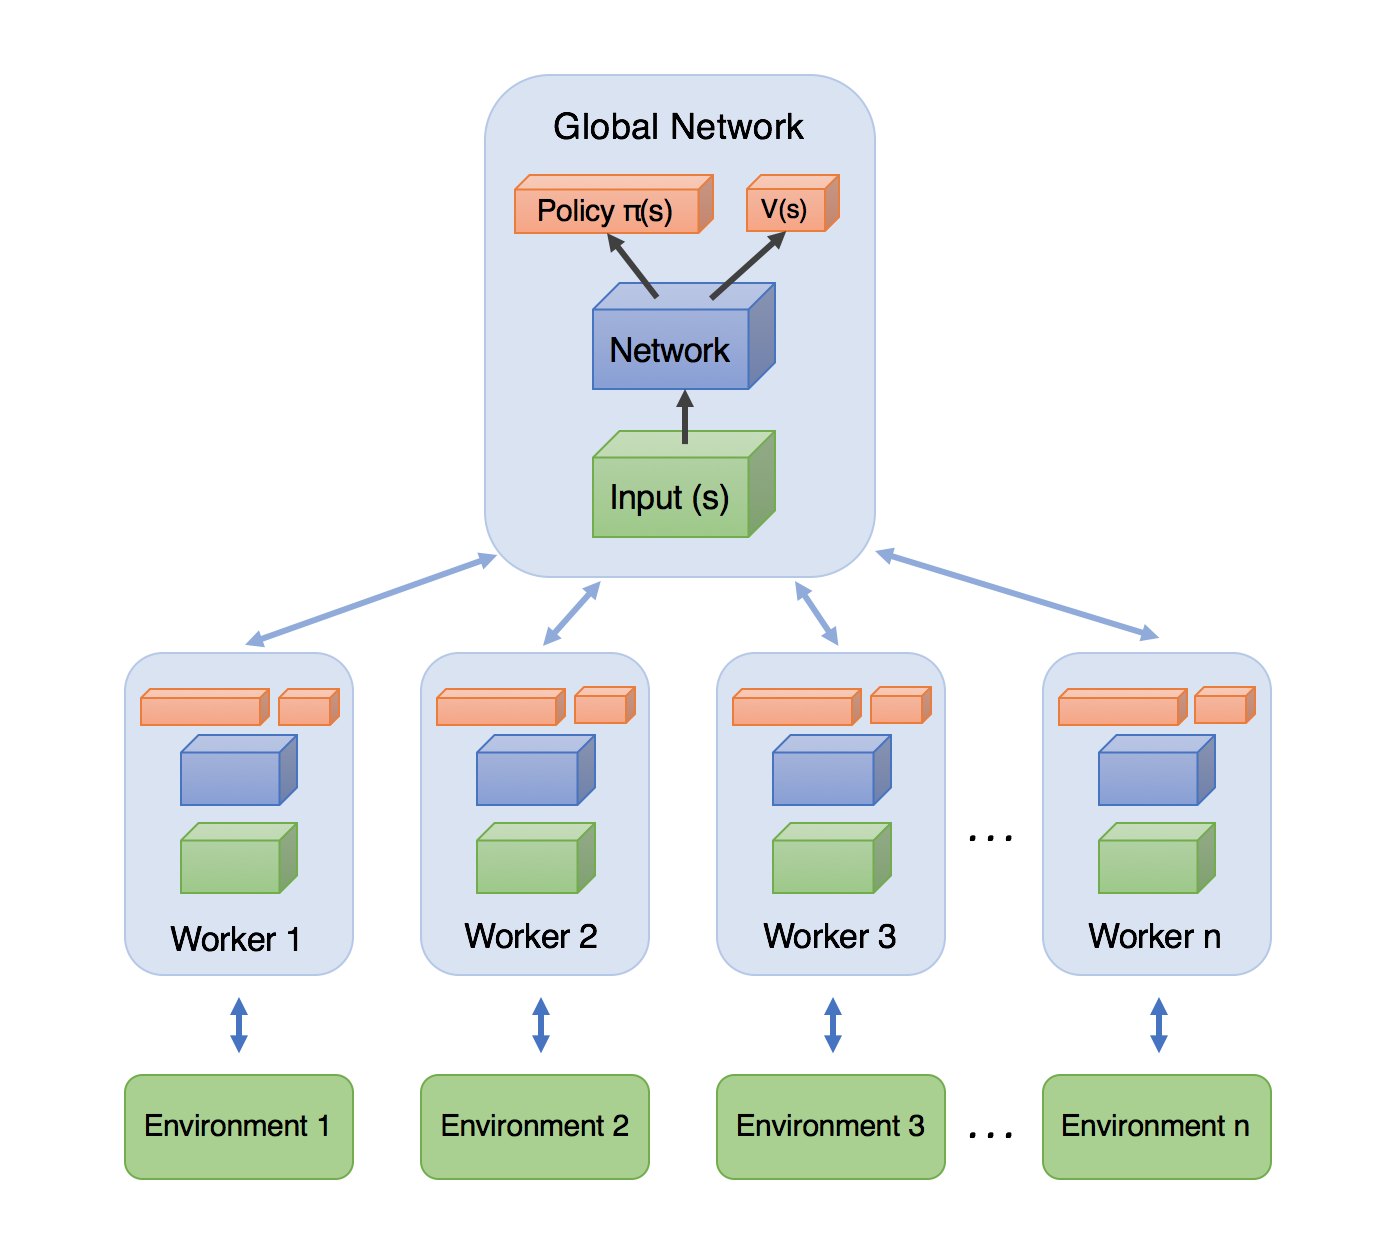

In [30]:
Image('1.png',width=600)

## 3.3 어떻게 A3C에서는 여러 액터-러너actor-learner를 각 env에서 play하게 하는가?  
  
 > 멀티 스레딩의 사용 때문이다.

## 3.4 멀티 스레딩

- 스레딩Treading이란?

- 멀티 스레딩이란? 

In [46]:
import itertools
import threading
import time as t
import multiprocessing
import numpy as np

class Worker:

    def __init__(self, id_, global_counter):

        self.id = id_
        self.global_counter = global_counter
        self.local_counter = itertools.count()

    def run(self):

        while True:

            time.sleep(np.random.rand()*2)
            global_step = next(self.global_counter)
            local_step = next(self.local_counter)

            print("Worker({}):{}".format(self.id,local_step))
            if global_step >= 20:
                break
"""
대역 카운터와 로컬 카운터가 서로 상호 업데이트 하는 동안에,
대역 카운터가 20 이상이 되면 중지
"""
global_counter = itertools.count()
NUM_WORKERS = multiprocessing.cpu_count()


일꾼 만들기

In [47]:
# 일꾼 만들기

workers=[]
for worker_id in range(NUM_WORKERS):
    worker = Worker(worker_id, global_counter)
    workers.append(worker)

쓰레드 시작

In [48]:
worker_threads=[]
for worker in workers:
    worker_fn = lambda: worker.run()
    t = threading.Thread(target=worker_fn)
    t.start()
    worker_threads.append(t)

쓰레드 조인

In [49]:
for t in worker_threads:
    t.join()

print("done!")

Worker(1):0
Worker(0):1
Worker(0):2
Worker(0):3
Worker(1):1
Worker(0):4
Worker(0):5
Worker(0):6
Worker(1):2
Worker(1):3
Worker(0):7
Worker(0):8
Worker(1):4
Worker(0):9
Worker(0):10
Worker(1):5
Worker(1):6
Worker(1):7
Worker(0):11
Worker(0):12
Worker(1):8
done!


# References  
[1] "파이썬과 케라스로 배우는 강화학습"  

[2]https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php  
[3] https://www.youtube.com/watch?v=iCV3vOl8IMk
